<a href="https://colab.research.google.com/github/jasxn808/Simple-Linear-Regression/blob/main/Linear_Regression_Rec_Yards_over_Expected_(RYOE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## simple Linear Regression model: Receiving Yards over Expected (RYOE)
## residual analysis: model expected Receiving Yards gained on play - actual (Rec) yards gained = RYOE

In [3]:
pip install nfl_data_py

In [83]:
## Python
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

seasons = range(2016, 2022 + 1)
pbp_py = nfl.import_pbp_data(seasons)

In [ ]:
pd.options.display.max_columns = None
#receiver_player_id	, receiver_player_name, receiving_yards
## removing pass plays where receiver_player_id is null (sack, incomplete pass, penalty)
pbp_py_pass = pbp_py.query('play_type == "pass" & receiver_player_id.notnull() ')



pbp_py_pass.sort_values(by = ['receiving_yards'], ascending = True)['receiving_yards']

#pbp_py_pass.query('receiving_yards.isnull()')[{'desc', 'receiver_player_id', 'receiver_player_name', 'receiving_yards'}]


#replacing NaN with 0
pbp_py_pass['receiving_yards'].fillna(0, inplace = True)
pbp_py_pass.reset_index(inplace=True)

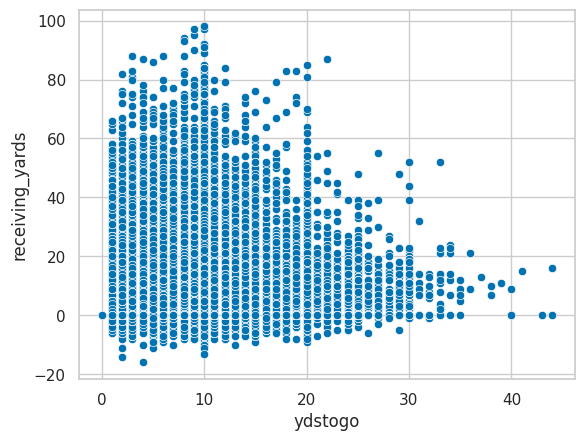

In [52]:
## Plotting rec_yards distribution
sns.set_theme(style="whitegrid", palette="colorblind")
sns.scatterplot(data=pbp_py_pass, x="ydstogo", y="receiving_yards");
plt.show();

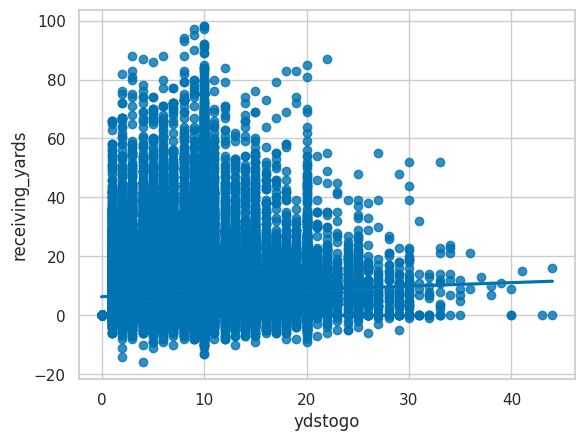

In [53]:
## trend line to see  data slope (upward, downward, or neither)
sns.regplot(data=pbp_py_pass, x="ydstogo", y="receiving_yards");
plt.show();

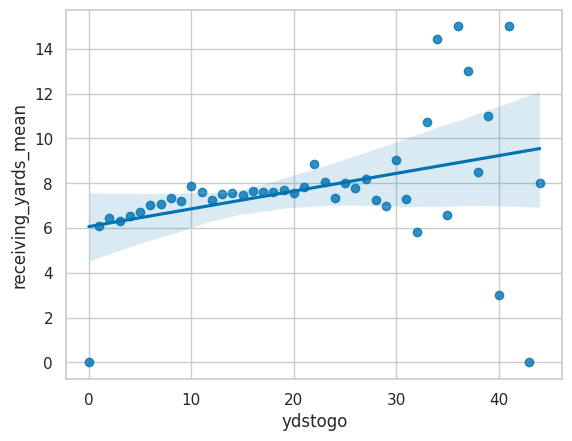

In [80]:
#determing avg receiving yards per ydstogo
  pbp_pass_avg = \
  pbp_py_pass.groupby('ydstogo')\
    .agg({'receiving_yards':['count', 'mean']})

  pbp_pass_avg.columns = list(map('_'.join, pbp_pass_avg.columns))
  pbp_pass_avg.reset_index(inplace=True)


sns.regplot(data=pbp_pass_avg, x="ydstogo", y="receiving_yards_mean");
plt.show();

In [98]:
## Simple Linear Regression - ydstogo predicts receiving yards
## formula: receiving_yards ~ 1 + ydstogo


#ordinary least-squares regression : estimates coefficients of linear regression equations
yds_to_go_py = smf.ols(formula = 'receiving_yards ~ 1 + ydstogo',\
                   data = pbp_py_pass)

#fitting = measurement of how well ML model adapts to data that is similar to the data on which it was trained
print(yds_to_go_py.fit().summary())

#creating residuals column:
pbp_py_pass['ryoe'] = \
    yds_to_go_py.fit().resid


                            OLS Regression Results                            
Dep. Variable:        receiving_yards   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     317.8
Date:                Fri, 13 Oct 2023   Prob (F-statistic):           5.21e-71
Time:                        23:36:26   Log-Likelihood:            -4.7460e+05
No. Observations:              128585   AIC:                         9.492e+05
Df Residuals:                  128583   BIC:                         9.492e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2984      0.065     96.422      0.0

In [169]:
#aggregations:
#receiver_player_id	, receiver_player_name, receiving_yards

ryoe_py = \
pbp_py_pass\
  .groupby(['season', 'receiver_player_id', 'receiver_player_name'])\
  .agg({'ryoe':['count', 'sum', 'mean']\
       , 'receiving_yards':['mean']})

ryoe_py.columns = list(map('_'.join, ryoe_py.columns))
ryoe_py.reset_index(inplace=True)

ryoe_py.rename(columns= {'ryoe_count':'n', 'ryoe_mean':'avg_ryoe', 'receiving_yards_mean':'ypr_avg'}, inplace=True)


#dont want trick plays / outliers
ryoe_py = ryoe_py.query('n > 10').reset_index()

ryoe_py.sort_values(by='ryoe_sum', ascending = False)


,index,season,receiver_player_id,receiver_player_name,n,ryoe_sum,avg_ryoe,ypr_avg
1797,2792,2021,00-0033908,C.Kupp,234,714.806309,3.054728,10.363248
1966,3096,2021,00-0036900,J.Chase,163,627.372477,3.848911,11.184049
71,98,2016,00-0027944,J.Jones,154,599.509927,3.892922,11.318182
1896,2963,2021,00-0035719,D.Samuel,135,549.559768,4.070813,11.488889
827,1250,2018,00-0032211,T.Lockett,77,517.683225,6.723159,14.090909
...,...,...,...,...,...,...,...,...
2067,3250,2022,00-0033699,A.Ekeler,131,-255.818462,-1.952813,5.465649
172,234,2016,00-0030525,T.Austin,106,-274.241517,-2.587184,4.801887
1732,2698,2021,00-0032688,R.Anderson,110,-295.060115,-2.682365,4.718182
474,705,2017,00-0031045,C.Hyde,88,-306.585943,-3.483931,3.977273


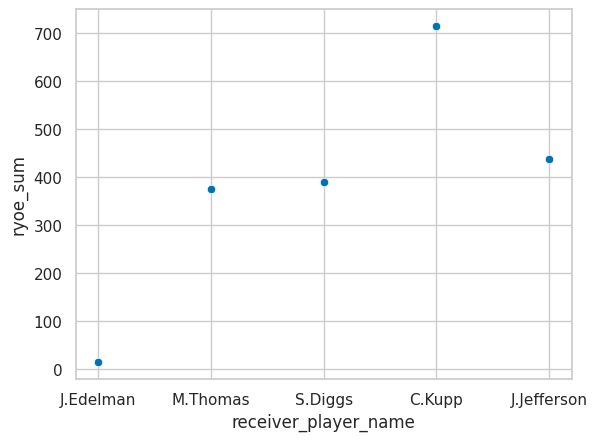

In [183]:
## elite WR plotting

ryoe_wr_starters = ryoe_py.query('n > 190')

sns.scatterplot(data=ryoe_wr_starters, x="receiver_player_name", y="ryoe_sum");

In [159]:
## stability analysis:

ryoe_py_CY = ryoe_py.copy()
ryoe_py_LY = ryoe_py.copy()


ryoe_py_LY['season'] += 1

ryoe_comparison = \
  ryoe_py_CY\
  .merge(ryoe_py_LY\
         ,how='left'\
         ,on=['season', 'receiver_player_id', 'receiver_player_name'])\
  [['season', 'receiver_player_name', 'avg_ryoe_x','ypr_avg_x', 'avg_ryoe_y','ypr_avg_y']]

ryoe_comparison.fillna(0, inplace=True)
ryoe_comparison.rename(columns = {'avg_ryoe_x': 'ryoe_CY', 'ypr_avg_x':'ypr_CY', 'avg_ryoe_y':'ryoe_LY', 'ypr_avg_y':'ypr_LY'}, inplace=True)

ryoe_comparison.query('receiver_player_name == "K.Pitts"')

,season,receiver_player_name,ryoe_CY,ypr_CY,ryoe_LY,ypr_LY
1975,2021,K.Pitts,1.989832,9.327272,0.000000,0.000000
2253,2022,K.Pitts,-1.191513,6.033898,1.989832,9.327272


In [161]:
#correlation comparison:

ryoe_comparison[['ypr_CY', 'ypr_LY']].corr()

,ypr_CY,ypr_LY
ypr_CY,1.000000,0.153025
ypr_LY,0.153025,1.000000


In [162]:
ryoe_comparison[['ryoe_CY', 'ryoe_LY']].corr()

## ryoe = slightly more stable metric than ypr

,ryoe_CY,ryoe_LY
ryoe_CY,1.000000,0.250449
ryoe_LY,0.250449,1.000000
